In [1]:
library(ranger)   # for Random Forest models
library(xgboost)  # for XGBoost models
library(tidyverse)
library(broom)
library(tidymodels)
library(vip)
library(DALEXtra)
options(scipen = 999)



── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ dplyr::slice()  masks xgboost::slice()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ dials        1.2.1      ✔ rsample      1.2.0 
✔ infer        1.0.6      ✔ tune         1.1.2 
✔ modeldata    1.3.0      ✔ workflows    1.1.4 
✔ parsnip      1.2.0      ✔ workflowsets 1.0.1 
✔ recipes      1.0.10     ✔ yardstick    1.3.0 

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr

In [2]:
insurance <- read_csv('../DataSets/insurance.csv')

# are there any missing values ?
any(is.na(insurance))

table(insurance$region)

# the liniear model, just as a baseline
lm_insur <- lm(charges ~ ., data = insurance)
summary(lm_insur)


Rows: 1338 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): sex, smoker, region
dbl (4): age, bmi, children, charges

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] FALSE


northeast northwest southeast southwest 
      324       325       364       325 


Call:
lm(formula = charges ~ ., data = insurance)

Residuals:
     Min       1Q   Median       3Q      Max 
-11304.9  -2848.1   -982.1   1393.9  29992.8 

Coefficients:
                Estimate Std. Error t value             Pr(>|t|)    
(Intercept)     -11938.5      987.8 -12.086 < 0.0000000000000002 ***
age                256.9       11.9  21.587 < 0.0000000000000002 ***
sexmale           -131.3      332.9  -0.394             0.693348    
bmi                339.2       28.6  11.860 < 0.0000000000000002 ***
children           475.5      137.8   3.451             0.000577 ***
smokeryes        23848.5      413.1  57.723 < 0.0000000000000002 ***
regionnorthwest   -353.0      476.3  -0.741             0.458769    
regionsoutheast  -1035.0      478.7  -2.162             0.030782 *  
regionsouthwest   -960.0      477.9  -2.009             0.044765 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6062 on 1329 degrees of freedom
Multiple R-squa

### Main Split of the data

In [3]:
set.seed(1234)
splits   <- initial_split(insurance, prop = 0.75)
train_tbl <- training(splits)
test_tbl  <- testing(splits)


## cross-validation folds
set.seed(1234)
cv_train <- vfold_cv(train_tbl, v = 5, repeats = 1)
cv_train


splits                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

### Data Recipe

In [4]:
the_recipe <- recipe(charges ~ ., data = train_tbl) %>%
    step_dummy(all_nominal(), -all_outcomes()) %>% # dummification of the predictors
    step_impute_knn(all_predictors(), neighbors = 3) %>%   # ... when having missing values
    step_zv(all_predictors()) # this removes predictors with zero variance


### Models Specifications

In [5]:
## Random Forest models
rf_spec <- rand_forest(
     mtry = tune(),    # first hyper-parameter to be tuned
     trees = 500,
     min_n = tune()     # second hyper-parameter to be tuned
          ) %>%
     set_engine("ranger") %>%
     set_mode("regression")

rf_spec


### XGBoost models
xgb_spec <- boost_tree(
    trees = 700, 
    tree_depth = tune(), min_n = tune(), 
    loss_reduction = tune(),                     ## model complexity
    sample_size = tune(), mtry = tune(),         ## randomness
    learn_rate = tune()                          ## step size
    ) %>% 
    set_engine("xgboost") %>% 
    set_mode("regression")

xgb_spec

Random Forest Model Specification (regression)

Main Arguments:
  mtry = tune()
  trees = 500
  min_n = tune()

Computational engine: ranger 


Boosted Tree Model Specification (regression)

Main Arguments:
  mtry = tune()
  trees = 700
  min_n = tune()
  tree_depth = tune()
  learn_rate = tune()
  loss_reduction = tune()
  sample_size = tune()

Computational engine: xgboost 


### Parameter grids Specifications

In [8]:
set.seed(1234)
rf_grid <- dials::grid_random(
    finalize(mtry(), train_tbl %>% select (-charges)),
    min_n(),  
    size = 20)  # the number should be larger, but it would take longer
rf_grid

mtry min_n
1  4    22   
2  2    21   
3  6     4   
4  5    37   
5  4    32   
6  1    30   
7  5     6   
8  6     3   
9  4    21   
10 2     4   
11 6    24   
12 2    37   
13 6     9   
14 6    33   
15 4     3   
16 6    16   
17 6    39   
18 6     7   
19 4    30   
20 4    33

In [9]:
set.seed(1234)
xgb_grid <- dials::grid_random(
    tree_depth(),
    min_n(),
    loss_reduction(),
    sample_size = sample_prop(),
    finalize(mtry(), train_tbl %>% select (-charges)),
    learn_rate(),
    size = 50   # the number should be larger, but it would take longer
)
xgb_grid

tree_depth min_n loss_reduction      sample_size mtry learn_rate        
1  12          3     0.0000604815565386 0.6750202   3    0.0000009915275076
2  10         16    20.5023583235807969 0.9932644   2    0.0350187789648374
3   6         39     0.0000005375753114 0.2154428   3    0.0000011812731761
4   5          7     0.0000343409185882 0.8949156   6    0.0000000051955584
5  12         30     0.0000012745339002 0.8290750   4    0.0840392845564740
6  15         33     0.0016443466075903 0.8396661   3    0.0000086317534873
7   9          9     0.0337599808033652 0.8512324   5    0.0008305043340266
8   5         27     0.0003225658591795 0.7594590   1    0.0166262786532768
9   6         18    19.0127450829459868 0.9847396   3    0.0001377234896680
10  4          9     0.0004298792262888 0.6752841   2    0.0000004626608846
11  2         33     0.0000111939560018 0.6946792   3    0.0000004659407502
12  7         23     0.0000000425496991 0.5755234   3    0.0000000020641683
13  6         36     0.0000000008806792 0.3857444   2    0.0000000058885644
14 10         17     0.5998554382891094 0.7910699   2    0.0000000053688844
15  6          4     0.0000000499579384 0.5736776   3    0.0000004739468115
16 15         23    23.1166894253997413 0.7590717   1    0.0000001361418839
17 14         11     0.0008352601798357 0.3768992   6    0.0032425421903988
18  4         23    30.5857611860737606 0.4637559   2    0.0000000061037968
19 14         26     0.0000020863772148 0.2839622   5    0.0057048967121868
20 14          4     0.0002420785201157 0.9870698   4    0.0000003755500225
21  8         20     0.0000086817159624 0.6096797   4    0.0000000023948808
22 14         27     0.0004193672185143 0.3523376   2    0.0000001131228789
23  4         24     0.0000094153196697 0.2665502   4    0.0000002016619474
24  4          7     0.0000000385235487 0.7822553   1    0.0000007021206496
25  5         21     0.0000000009491273 0.6101032   5    0.0000000047537040
26  8          8     0.0021327010658330 0.9389562   6    0.0000835890527468
27  4         33     0.0000090508269186 0.6748240   6    0.0192177451818735
28  8          7     0.0000000006858594 0.7306733   3    0.0004027602152125
29  3         38     0.1688975001305681 0.5313002   3    0.0087271701655241
30  4         28     0.0000005504279625 0.8652807   4    0.0380293392968566
31 15         13     0.0511474401289893 0.4800976   4    0.0000000056769336
32 15          9     0.0005237480867708 0.1282529   3    0.0000017928775058
33 13          2     0.0141792473077607 0.3323320   3    0.0000002981644790
34 10         37     0.0000081324483542 0.4013603   1    0.0000002330734018
35  5         29     0.0000008934825465 0.2201947   3    0.0000000001781152
36  2         20     0.0536883218519257 0.5495917   5    0.0231311330195515
37 14         10     0.0000075222435800 0.8219221   1    0.0000004951804395
38 15         31     0.0002819703342888 0.4034379   6    0.0400462582920025
39  8         18     0.0000000021655160 0.5580286   1    0.0000000281433351
40 11         39     0.0000003053167799 0.5449947   4    0.0000045208327926
41  4         23     0.0000320797435175 0.8173476   4    0.0637952848064440
42 12          7     0.0000009237432709 0.6102630   5    0.0000002124556947
43  3         22     0.0008094920934354 0.1960271   3    0.0000000622119698
44  7         22     0.0000000007498221 0.8268836   2    0.0000000002031827
45  9         33     9.8608653359914804 0.6104009   5    0.0001018808659445
46  3         14     0.0000000001800439 0.2910168   5    0.0194199180014960
47  6         18     0.4782690450504206 0.7746213   4    0.0000000002540425
48  4          3     0.0018753751657936 0.3764965   5    0.0000000064594224
49  8          7     0.0000003681992497 0.5405666   1    0.0004916249988133
50 10          3     0.0346375935486385 0.9907389   5    0.0000000014962752

### Assembling the models with workflows

In [6]:
wf_rf <- workflow() %>%
    add_model(rf_spec) %>%
    add_recipe(the_recipe)

wf_xgb <- workflow() %>%
    add_model(xgb_spec) %>%
    add_recipe(the_recipe)

### Fit the models for all cross-validation folds 

In [10]:

set.seed(1234)
rf_resamples <- wf_rf %>% 
    tune_grid(
      resamples = cv_train,
      grid = rf_grid
              )
rf_resamples


set.seed(1234)
xgb_resamples <- wf_xgb %>% 
    tune_grid(
      resamples = cv_train,
      grid = xgb_grid
    )
xgb_resamples


splits                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

splits                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

### Model evaluation

mtry min_n .metric .estimator mean         n std_err      
1  4    22    rmse    standard   4815.5622024 5 132.852276849
2  4    22    rsq     standard      0.8484791 5   0.010823339
3  2    21    rmse    standard   5705.3904053 5 141.102141757
4  2    21    rsq     standard      0.8277174 5   0.014601927
5  6     4    rmse    standard   4956.0357114 5 101.141077476
6  6     4    rsq     standard      0.8390243 5   0.009744170
7  5    37    rmse    standard   4797.0591091 5 124.570156185
8  5    37    rsq     standard      0.8487929 5   0.010363405
9  4    32    rmse    standard   4855.8170935 5 132.654611722
10 4    32    rsq     standard      0.8468339 5   0.011059230
11 1    30    rmse    standard   8603.5816449 5 150.888237871
12 1    30    rsq     standard      0.7801539 5   0.024849037
13 5     6    rmse    standard   4890.9245093 5 110.991420195
14 5     6    rsq     standard      0.8426645 5   0.010231862
15 6     3    rmse    standard   4970.3288710 5  99.404346672
16 6     3    rsq     standard      0.8378654 5   0.010151751
17 4    21    rmse    standard   4828.3776599 5 129.921285813
18 4    21    rsq     standard      0.8474438 5   0.010992152
19 2     4    rmse    standard   5437.9457992 5 140.531537906
20 2     4    rsq     standard      0.8364365 5   0.014278675
21 6    24    rmse    standard   4810.8144845 5 122.062114985
22 6    24    rsq     standard      0.8473778 5   0.010473280
23 2    37    rmse    standard   5968.3579336 5 109.793369905
24 2    37    rsq     standard      0.8209040 5   0.014412119
25 6     9    rmse    standard   4899.4219112 5 105.800982833
26 6     9    rsq     standard      0.8423915 5   0.009841474
27 6    33    rmse    standard   4784.0170393 5 119.640257253
28 6    33    rsq     standard      0.8490791 5   0.010035793
29 4     3    rmse    standard   4866.3041179 5 114.883842327
30 4     3    rsq     standard      0.8440746 5   0.010226526
31 6    16    rmse    standard   4844.6909881 5 116.121045344
32 6    16    rsq     standard      0.8456831 5   0.010025748
33 6    39    rmse    standard   4766.9981381 5 126.343261156
34 6    39    rsq     standard      0.8501335 5   0.010082031
35 6     7    rmse    standard   4935.3579727 5 104.446576106
36 6     7    rsq     standard      0.8402614 5   0.009805790
37 4    30    rmse    standard   4847.2058524 5 123.874716849
38 4    30    rsq     standard      0.8474461 5   0.010316258
39 4    33    rmse    standard   4856.9656126 5 133.028213948
40 4    33    rsq     standard      0.8471283 5   0.010846509
   .config              
1  Preprocessor1_Model01
2  Preprocessor1_Model01
3  Preprocessor1_Model02
4  Preprocessor1_Model02
5  Preprocessor1_Model03
6  Preprocessor1_Model03
7  Preprocessor1_Model04
8  Preprocessor1_Model04
9  Preprocessor1_Model05
10 Preprocessor1_Model05
11 Preprocessor1_Model06
12 Preprocessor1_Model06
13 Preprocessor1_Model07
14 Preprocessor1_Model07
15 Preprocessor1_Model08
16 Preprocessor1_Model08
17 Preprocessor1_Model09
18 Preprocessor1_Model09
19 Preprocessor1_Model10
20 Preprocessor1_Model10
21 Preprocessor1_Model11
22 Preprocessor1_Model11
23 Preprocessor1_Model12
24 Preprocessor1_Model12
25 Preprocessor1_Model13
26 Preprocessor1_Model13
27 Preprocessor1_Model14
28 Preprocessor1_Model14
29 Preprocessor1_Model15
30 Preprocessor1_Model15
31 Preprocessor1_Model16
32 Preprocessor1_Model16
33 Preprocessor1_Model17
34 Preprocessor1_Model17
35 Preprocessor1_Model18
36 Preprocessor1_Model18
37 Preprocessor1_Model19
38 Preprocessor1_Model19
39 Preprocessor1_Model20
40 Preprocessor1_Model20

avg_rsq  
1 0.8394946

mtry min_n tree_depth learn_rate         loss_reduction      sample_size
1   3     3    12         0.000000991527508   0.0000604815565386 0.6750202  
2   3     3    12         0.000000991527508   0.0000604815565386 0.6750202  
3   2    16    10         0.035018778964837  20.5023583235807969 0.9932644  
4   2    16    10         0.035018778964837  20.5023583235807969 0.9932644  
5   3    39     6         0.000001181273176   0.0000005375753114 0.2154428  
6   3    39     6         0.000001181273176   0.0000005375753114 0.2154428  
7   6     7     5         0.000000005195558   0.0000343409185882 0.8949156  
8   6     7     5         0.000000005195558   0.0000343409185882 0.8949156  
9   4    30    12         0.084039284556474   0.0000012745339002 0.8290750  
10  4    30    12         0.084039284556474   0.0000012745339002 0.8290750  
11  3    33    15         0.000008631753487   0.0016443466075903 0.8396661  
12  3    33    15         0.000008631753487   0.0016443466075903 0.8396661  
13  5     9     9         0.000830504334027   0.0337599808033652 0.8512324  
14  5     9     9         0.000830504334027   0.0337599808033652 0.8512324  
15  1    27     5         0.016626278653277   0.0003225658591795 0.7594590  
16  1    27     5         0.016626278653277   0.0003225658591795 0.7594590  
17  3    18     6         0.000137723489668  19.0127450829459868 0.9847396  
18  3    18     6         0.000137723489668  19.0127450829459868 0.9847396  
19  2     9     4         0.000000462660885   0.0004298792262888 0.6752841  
20  2     9     4         0.000000462660885   0.0004298792262888 0.6752841  
21  3    33     2         0.000000465940750   0.0000111939560018 0.6946792  
22  3    33     2         0.000000465940750   0.0000111939560018 0.6946792  
23  3    23     7         0.000000002064168   0.0000000425496991 0.5755234  
24  3    23     7         0.000000002064168   0.0000000425496991 0.5755234  
25  2    36     6         0.000000005888564   0.0000000008806792 0.3857444  
26  2    36     6         0.000000005888564   0.0000000008806792 0.3857444  
27  2    17    10         0.000000005368884   0.5998554382891094 0.7910699  
28  2    17    10         0.000000005368884   0.5998554382891094 0.7910699  
29  3     4     6         0.000000473946811   0.0000000499579384 0.5736776  
30  3     4     6         0.000000473946811   0.0000000499579384 0.5736776  
⋮   ⋮    ⋮     ⋮          ⋮                  ⋮                   ⋮          
71  5    20     2         0.0231311330195515 0.0536883218519257  0.5495917  
72  5    20     2         0.0231311330195515 0.0536883218519257  0.5495917  
73  1    10    14         0.0000004951804395 0.0000075222435800  0.8219221  
74  1    10    14         0.0000004951804395 0.0000075222435800  0.8219221  
75  6    31    15         0.0400462582920025 0.0002819703342888  0.4034379  
76  6    31    15         0.0400462582920025 0.0002819703342888  0.4034379  
77  1    18     8         0.0000000281433351 0.0000000021655160  0.5580286  
78  1    18     8         0.0000000281433351 0.0000000021655160  0.5580286  
79  4    39    11         0.0000045208327926 0.0000003053167799  0.5449947  
80  4    39    11         0.0000045208327926 0.0000003053167799  0.5449947  
81  4    23     4         0.0637952848064440 0.0000320797435175  0.8173476  
82  4    23     4         0.0637952848064440 0.0000320797435175  0.8173476  
83  5     7    12         0.0000002124556947 0.0000009237432709  0.6102630  
84  5     7    12         0.0000002124556947 0.0000009237432709  0.6102630  
85  3    22     3         0.0000000622119698 0.0008094920934354  0.1960271  
86  3    22     3         0.0000000622119698 0.0008094920934354  0.1960271  
87  2    22     7         0.0000000002031827 0.0000000007498221  0.8268836  
88  2    22     7         0.0000000002031827 0.0000000007498221  0.8268836  
89  5    33     9         0.0001018808659445 9.8608653359914804  0.6104009  
90  5    33     9         0.0001018808659445 9.8608653359914804  0.6104009  


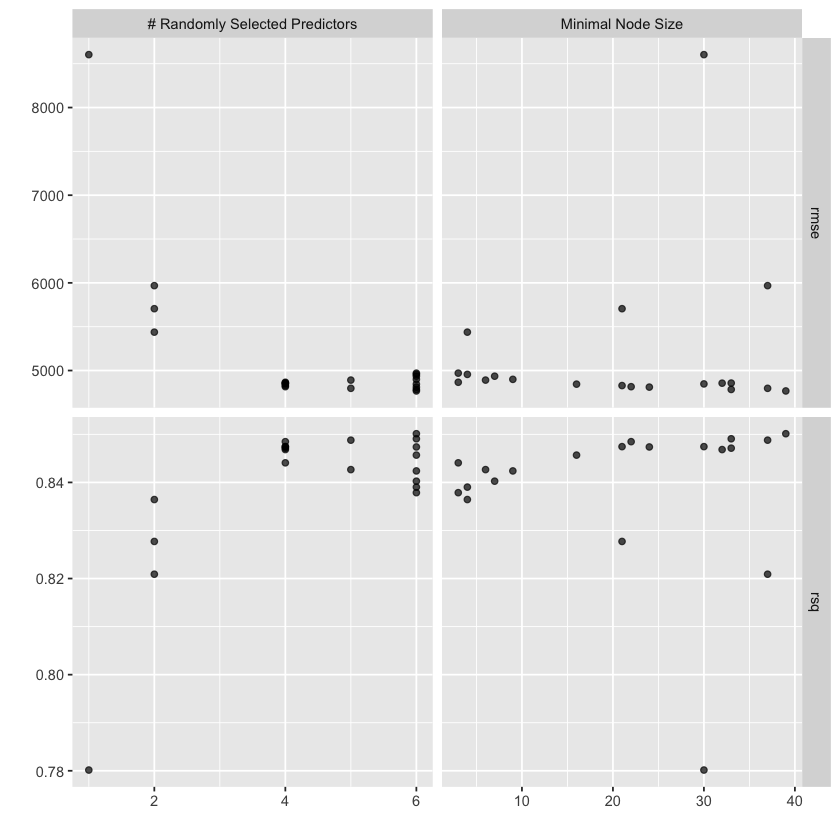

avg_rsq  
1 0.7991098

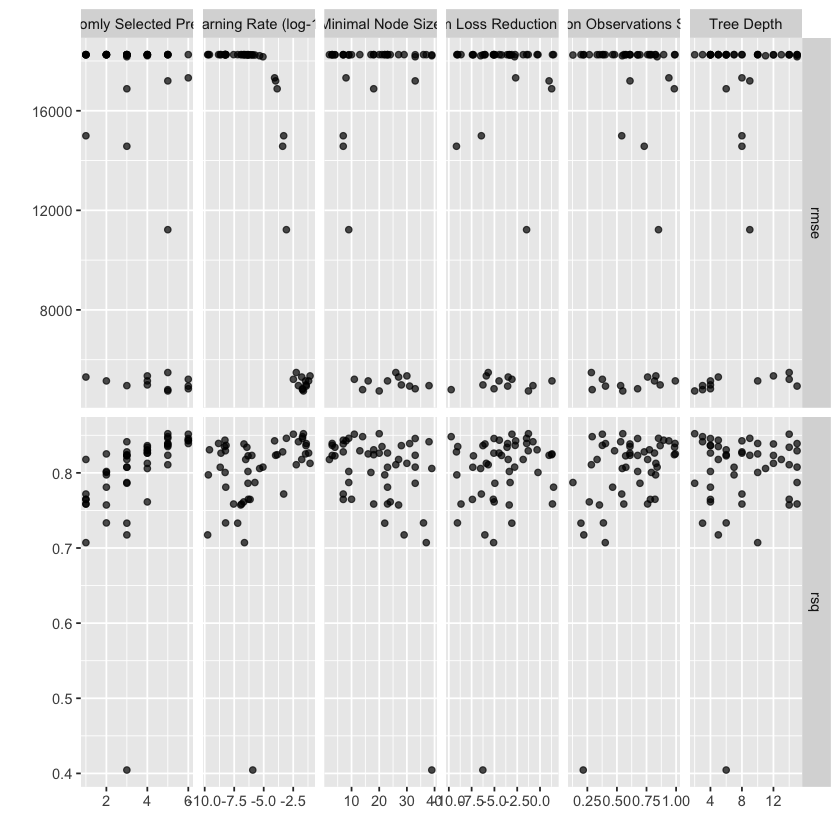

In [11]:

# performance metrics (mean) across folds for each grid line
temp <- rf_resamples %>% collect_metrics()
View(temp)
autoplot(rf_resamples)

rf_resamples %>% 
    collect_metrics() %>%
    filter(`.metric` == 'rsq') %>%
    summarise(avg_rsq = mean(mean))


xgb_resamples %>% collect_metrics()
autoplot(xgb_resamples)

xgb_resamples %>% 
    collect_metrics() %>%
    filter(`.metric` == 'rsq') %>%
    summarise(avg_rsq = mean(mean))


### Choose the best combination of hyper-parameter values

In [12]:
best_rf <- rf_resamples %>% select_best("rmse")
best_rf

best_xgb <- xgb_resamples %>% select_best("rmse")
best_xgb

mtry min_n .config              
1 6    39    Preprocessor1_Model17

mtry min_n tree_depth learn_rate loss_reduction sample_size
1 5    20    2          0.02313113 0.05368832     0.5495917  
  .config              
1 Preprocessor1_Model36

### Finalize the models

In [13]:
final_wf_rf <- wf_rf %>% 
     finalize_workflow(best_rf)

final_wf_xgb <- wf_xgb %>% 
    finalize_workflow(best_xgb)


### Variable importance

[00:47:08] WARNING: src/learner.cc:767: 
Parameters: { "importance" } are not used.



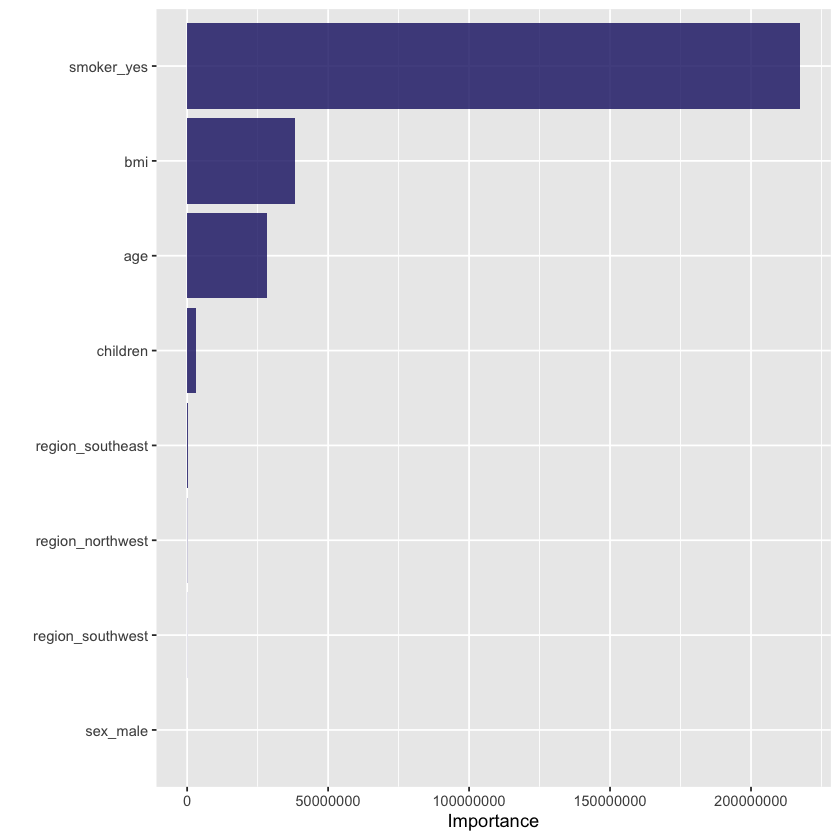

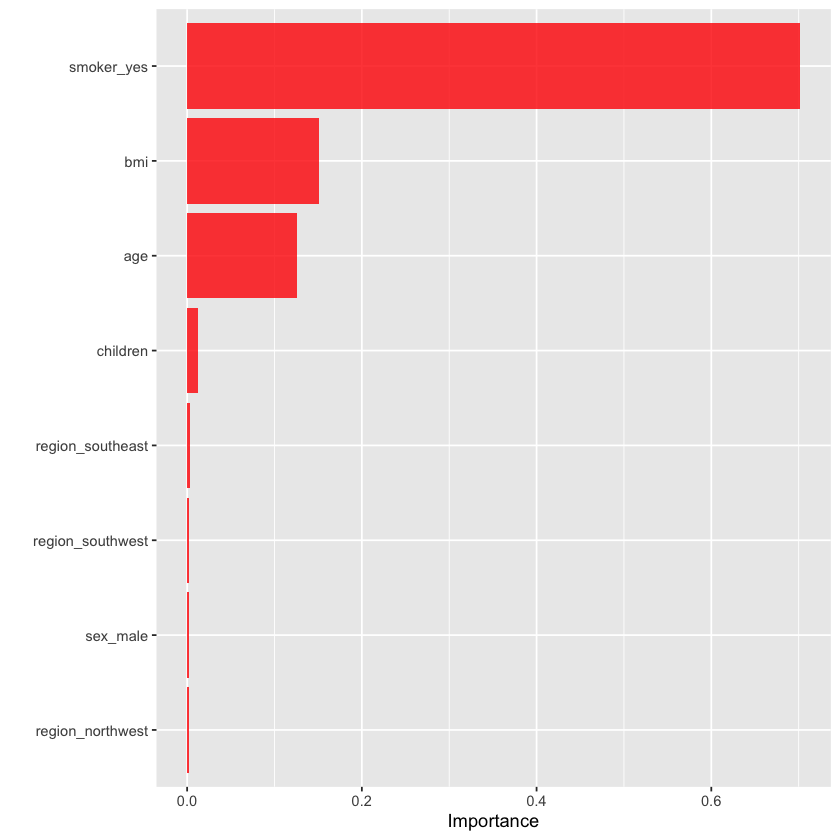

In [14]:
set.seed(1234)
rf_imp_spec <- rf_spec %>%
    finalize_model(best_rf) %>%
    set_engine("ranger", importance = "permutation")

workflow() %>%
    add_recipe(the_recipe) %>%
    add_model(rf_imp_spec) %>%
    fit(train_tbl) %>%
    extract_fit_parsnip() %>%
    vip(aesthetics = list(alpha = 0.8, fill = "midnightblue"))



set.seed(1234)
xgb_imp_spec <- xgb_spec %>%
    finalize_model(best_xgb) %>%
    set_engine("xgboost", importance = "permutation")

workflow() %>%
    add_recipe(the_recipe) %>%
    add_model(xgb_imp_spec) %>%
    fit(train_tbl) %>%
    extract_fit_parsnip() %>%
    vip(aesthetics = list(alpha = 0.8, fill = "red"))

### Model performance on the test set

In [15]:
set.seed(1234)
test__rf <- final_wf_rf %>% last_fit(splits) 
test__rf %>% collect_metrics() 

set.seed(1234)
test__xgb <- final_wf_xgb %>% last_fit(splits) 
test__xgb %>% collect_metrics() 

.metric .estimator .estimate    .config             
1 rmse    standard   3957.0130473 Preprocessor1_Model1
2 rsq     standard      0.8818539 Preprocessor1_Model1

.metric .estimator .estimate    .config             
1 rmse    standard   3852.7964357 Preprocessor1_Model1
2 rsq     standard      0.8874609 Preprocessor1_Model1

---
---
---

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


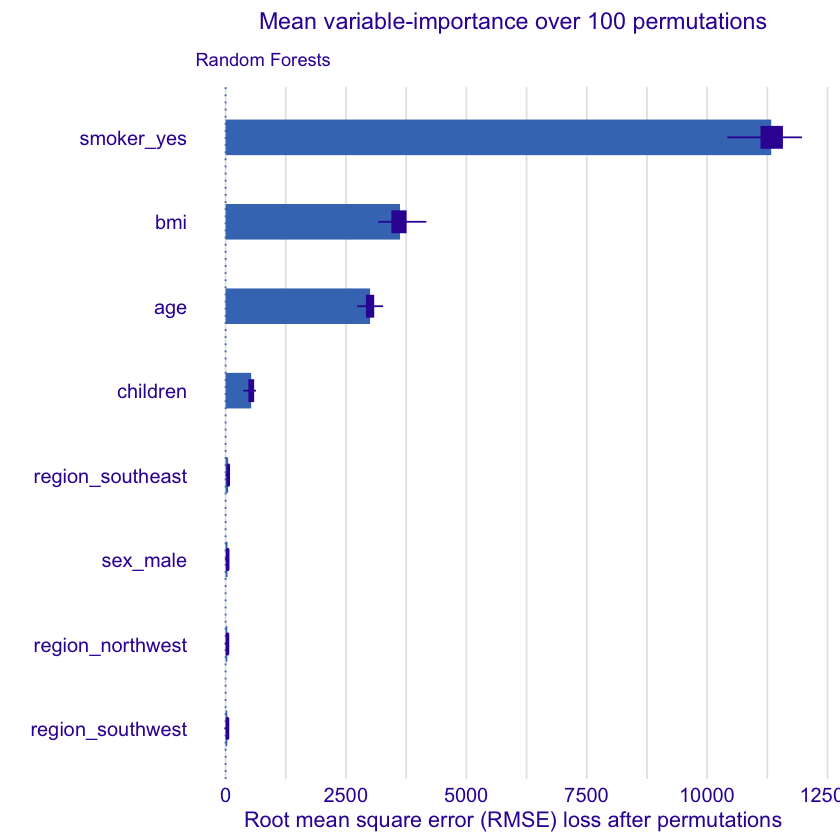

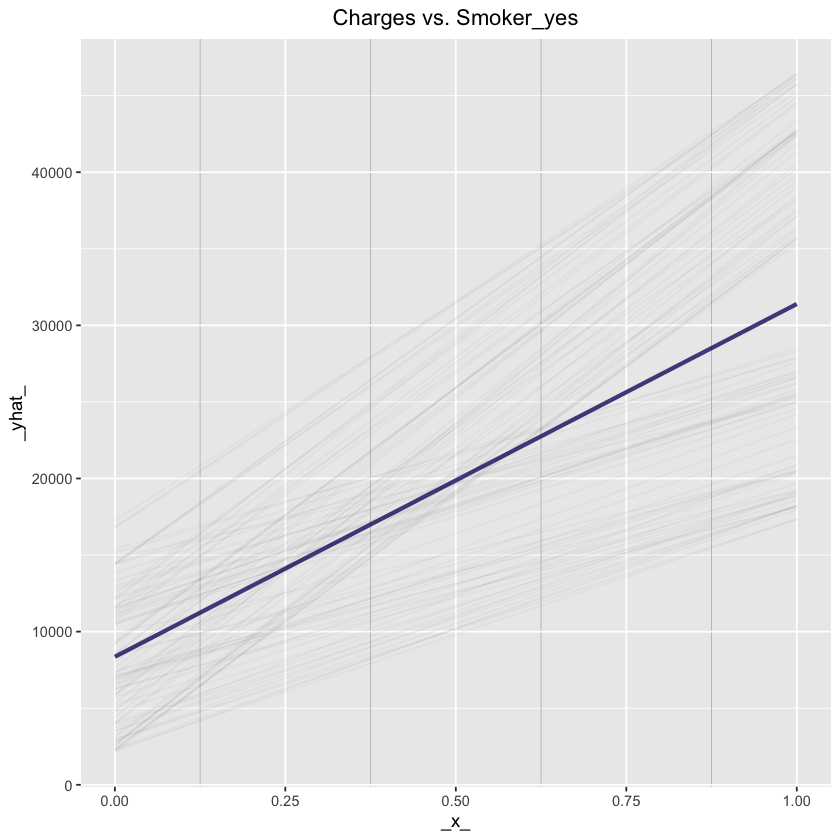

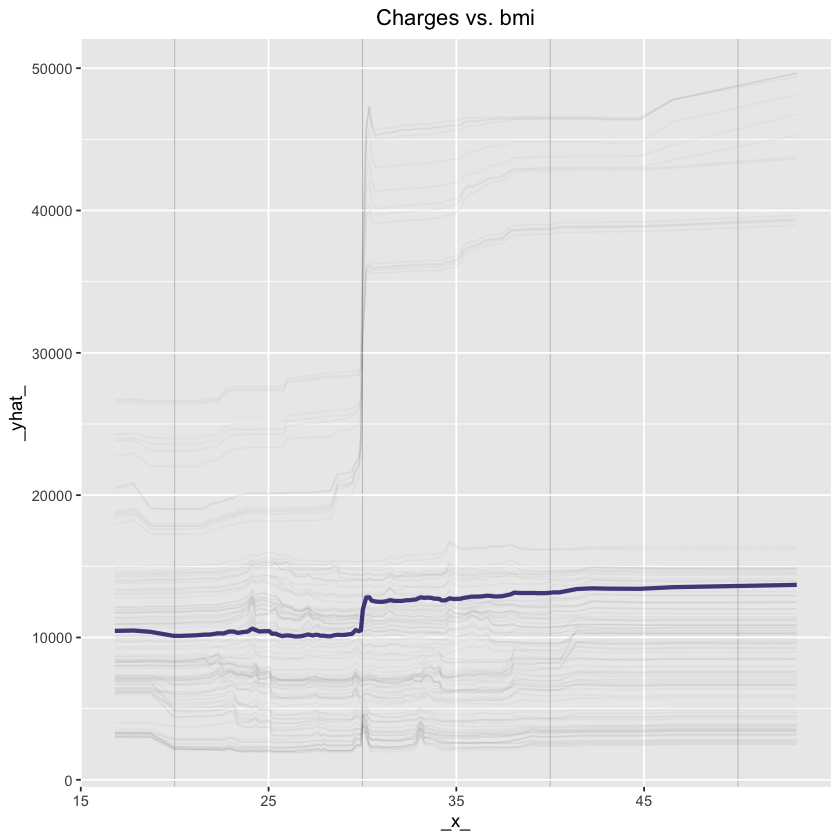

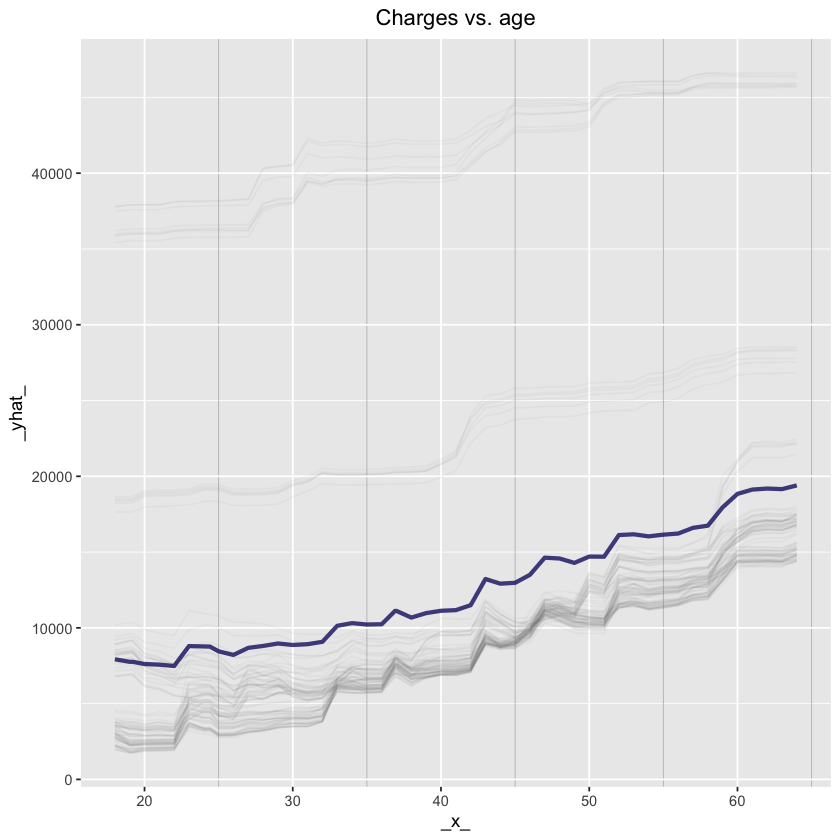

In [16]:
imp_data <- the_recipe |>
     prep() |>
     bake(new_data = NULL)


# Final model with the best parameters
set.seed(1234)
df_spec_final_rf <- rf_spec |>
     finalize_model(best_rf) |>
     set_engine("ranger", importance = "permutation")

#building the explainer-object
explainer_rf <- DALEXtra::explain_tidymodels(
     df_spec_final_rf |> 
          fit(charges ~ ., data = imp_data),
          data = imp_data %>% select(-charges), 
          y = train_tbl$charges,
     verbose = FALSE
     )

# Calculates the variable-importance measure
set.seed(1234)
vip_df <- model_parts( 
     explainer = explainer_rf, 
     loss_function = loss_root_mean_square, 
     B = 100, #the number of permutations
     type = "difference",
     label =""
  )

# Plotting ranking of the importance of explanatory variables
plot(vip_df) +
     ggtitle("Mean variable-importance over 100 permutations", "\nRandom Forests")+
     theme(plot.title = element_text(hjust = 0.5, size = 14),
        axis.title.x = element_text(size=13),
        axis.text = element_text(size=12)) 


# Partial dependence profiles for smokers
set.seed(1234)
pdp_smoker <- model_profile(explainer_rf, variables = "smoker_yes")
 
as_tibble(pdp_smoker$agr_profiles) |>
     ggplot(aes(`_x_`, `_yhat_`)) +
     geom_line(data = as_tibble(pdp_smoker$cp_profiles),
            aes(x = smoker_yes, group = `_ids_`),
            size = 0.5, alpha = 0.05, color = "gray50")+
     geom_line(color = "midnightblue", linewidth = 1.2, alpha = 0.8)+
     labs(title= "Charges vs. Smoker_yes")+
     theme(plot.title = element_text(hjust = 0.5),
        panel.grid.minor.x = element_line(color="grey"))


# Partial dependence profiles for bmi
set.seed(1234)
pdp_bmi <- model_profile(explainer_rf, variables = "bmi")
 
as_tibble(pdp_bmi$agr_profiles) |>
     ggplot(aes(`_x_`, `_yhat_`)) +
     geom_line(data = as_tibble(pdp_bmi$cp_profiles),
            aes(x = bmi, group = `_ids_`),
            size = 0.5, alpha = 0.05, color = "gray50")+
     geom_line(color = "midnightblue", linewidth = 1.2, alpha = 0.8)+
     labs(title= "Charges vs. bmi")+
     theme(plot.title = element_text(hjust = 0.5),
        panel.grid.minor.x = element_line(color="grey"))


# Partial dependence profiles for age
set.seed(1234)
pdp_age <- model_profile(explainer_rf, variables = "age")
 
as_tibble(pdp_age$agr_profiles) |>
     ggplot(aes(`_x_`, `_yhat_`)) +
     geom_line(data = as_tibble(pdp_age$cp_profiles),
            aes(x = age, group = `_ids_`),
            size = 0.5, alpha = 0.05, color = "gray50")+
     geom_line(color = "midnightblue", linewidth = 1.2, alpha = 0.8)+
     labs(title= "Charges vs. age")+
     theme(plot.title = element_text(hjust = 0.5),
        panel.grid.minor.x = element_line(color="grey"))